# Trabajo: Minería de texto
#### Daniel Marín López & Guadalupe Luna Velázquez

## Introducción
### ¿Qué es la mineria de texto?

La **minería de texto** es el proceso de transformar el texto no estructurado en una forma estructurada que ayude a identificar patrones significativos y nueva información.

Trabajar con datos no estructurados es una tarea para la IA, y si juntamos el análisis de texto entonces estamos ante un claro caso de NLP.

Algunos ejemplos clásicos son la identificación de correos con SPAM, análisis de sentimientos o, incluso, la minería de opiniones para las plataformas como IMDb.

---

## Se pide...

Realizar un sistema que al pasarle una letra de una canción detecte si pertenece a un género o no. En nuestro caso intentaremos que detecte el género pop.

## Como abordar el problema

Para poder abordar el problema se puede hacer de la siguiente forma:

1. **Recolección de datos**
2. **Preprocesamiento del texto**
  1. Limpieza de datos
  2. Tokenización
  3. Lematización/Stemming
  4. Eliminación de palabras vacías (stop words)
3. **Representación del texto**
  1. Bag of Words (BoW)
  2. TF-IDF
  3. Embeddings
4. **Selección del modelo**
5. **Entrenamiento y validación**
6. **Pruebas**

In [3]:
import os
import zipfile
import numpy as np
import pandas as pd
from google.colab import drive
import spacy
import matplotlib.pyplot as plt

!pip install transformers
!pip install tensorflow

## 1. Recolección de datos

Lo primero será recolectar el dataset que vamos a utilizar que tenga recopiladas un montón de canciones con su género respectivo.

Usaremos un dataset de kaggle llamado [Genius Song Lyrics](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information) que pesa 3GB y contiene las lyrics y los tags que es donde estarían los géneros.

Primero descargamos los datos y los descomprimimos.

In [10]:
os.makedirs("/content/data/.kaggle", exist_ok=True)
!mv /content/kaggle.json /content/.kaggle/
!chmod 600 /content/data/.kaggle/kaggle.json

# Descarga el dataset
!kaggle datasets download -d carlosgdcj/genius-song-lyrics-with-language-information

with zipfile.ZipFile("genius-song-lyrics-with-language-information.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

# Borramos el archivo zip

os.remove("/content/genius-song-lyrics-with-language-information.zip")

mv: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/content/data/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information
License(s): unknown
100% 3.04G/3.04G [00:55<00:00, 69.8MB/s]
100% 3.04G/3.04G [00:55<00:00, 59.1MB/s]


Una vez se han descargado los datos, los guardamos en un DataFrame de Pandas. Debido a la magnitud inmensa de los datos, optaremos por filtrar por la canciones cuyo género sea pop para que nuestro dataset sea minimamente procesado.

In [11]:
chunk_size = 100000  # Define el tamaño del chunk
chunks = []

for chunk in pd.read_csv('/content/data/song_lyrics.csv', chunksize=chunk_size):
    # Procesar cada chunk (por ejemplo, filtrar por idioma o género)
    chunk = chunk[(chunk['language'] == 'en') & (chunk['tag'] != 'pop')]
    chunks.append(chunk)

# Combina los chunks si es necesario
df = pd.concat(chunks)
df

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
5134825,Full-Time,rock,Ryan Egan,2022,4,{},Now that our tears fell to the floor\nWe can s...,7882797,en,en,en
5134827,Even In My Dreams,country,Julia Cole,2022,2,"{""Cooper Alan""}","[Verse 1: Julia Cole, Cooper Alan]\nHate hangi...",7882811,en,en,en
5134839,Bury You,rock,Mirror Lake (USA),2021,1,{},I'm dying from within\nI've run out of time\nT...,7882825,en,en,en
5134840,Reminiscing,rap,Ncognito,2022,2,{Iunique},Look I've been nice for too damn long\nGuess t...,7882826,en,en,en


Como opcional, vamos a guardar el DataFrame en un csv en nuestro Drive de forma que el tema de la memoria no sea un problema.

In [12]:
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'

os.makedirs(ruta, exist_ok=True)

ruta_archivo = os.path.join(ruta, 'all_non_pop_lyrics.csv')
df.to_csv(ruta_archivo, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Y por último podemos cargar el archivo filtrado desde drive sin tener que procesarlo entero de nuevo.

In [2]:
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'pop_lyrics.csv')
df01 = pd.read_csv(ruta_archivo)
df01 = df01[df01['language'] == 'en']
ruta2 = os.path.join(ruta, 'all_non_pop_lyrics.csv')
df02 = pd.read_csv(ruta2)
df02

Mounted at /content/drive


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
1980634,Full-Time,rock,Ryan Egan,2022,4,{},Now that our tears fell to the floor\nWe can s...,7882797,en,en,en
1980635,Even In My Dreams,country,Julia Cole,2022,2,"{""Cooper Alan""}","[Verse 1: Julia Cole, Cooper Alan]\nHate hangi...",7882811,en,en,en
1980636,Bury You,rock,Mirror Lake (USA),2021,1,{},I'm dying from within\nI've run out of time\nT...,7882825,en,en,en
1980637,Reminiscing,rap,Ncognito,2022,2,{Iunique},Look I've been nice for too damn long\nGuess t...,7882826,en,en,en


In [3]:
# prompt: fusiona los dos dataframes en uno solo

# Concatenate the two dataframes
df_combined = pd.concat([df01, df02], ignore_index=True)

# Display the combined dataframe (optional)
df_combined

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Wordy Rappinghood,pop,Tom Tom Club,1981,26499,{},[Chorus]\nWhat are words worth?\nWhat are word...,242,en,en,en
1,Horchata,pop,Vampire Weekend,2009,102550,{},"[Verse 1]\nIn December, drinking horchata\nI'd...",384,en,en,en
2,Heartless,pop,Kanye West,2008,1175109,{},"[Chorus]\nIn the night, I hear 'em talk\nThe c...",526,en,en,en
3,Flashing Lights,pop,Kanye West,2007,1078113,{Dwele},[Intro: Connie Mitchell]\nFlashing lights (Lig...,523,en,en,en
4,Baby,pop,Justin Bieber,2010,2232442,{Ludacris},[Produced by The-Dream and Tricky Stewart]\n\n...,566,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
3374193,Full-Time,rock,Ryan Egan,2022,4,{},Now that our tears fell to the floor\nWe can s...,7882797,en,en,en
3374194,Even In My Dreams,country,Julia Cole,2022,2,"{""Cooper Alan""}","[Verse 1: Julia Cole, Cooper Alan]\nHate hangi...",7882811,en,en,en
3374195,Bury You,rock,Mirror Lake (USA),2021,1,{},I'm dying from within\nI've run out of time\nT...,7882825,en,en,en
3374196,Reminiscing,rap,Ncognito,2022,2,{Iunique},Look I've been nice for too damn long\nGuess t...,7882826,en,en,en


In [ ]:
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'

os.makedirs(ruta, exist_ok=True)

ruta_archivo = os.path.join(ruta, 'all_pop_en.csv')
df_combined.to_csv(ruta_archivo, index=False)

In [4]:
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'all_pop_en.csv')
df = pd.read_csv(ruta_archivo)
df

Mounted at /content/drive


,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Wordy Rappinghood,pop,Tom Tom Club,1981,26499,{},[Chorus]\nWhat are words worth?\nWhat are word...,242,en,en,en
1,Horchata,pop,Vampire Weekend,2009,102550,{},"[Verse 1]\nIn December, drinking horchata\nI'd...",384,en,en,en
2,Heartless,pop,Kanye West,2008,1175109,{},"[Chorus]\nIn the night, I hear 'em talk\nThe c...",526,en,en,en
3,Flashing Lights,pop,Kanye West,2007,1078113,{Dwele},[Intro: Connie Mitchell]\nFlashing lights (Lig...,523,en,en,en
4,Baby,pop,Justin Bieber,2010,2232442,{Ludacris},[Produced by The-Dream and Tricky Stewart]\n\n...,566,en,en,en
...,...,...,...,...,...,...,...,...,...,...,...
3374193,Full-Time,rock,Ryan Egan,2022,4,{},Now that our tears fell to the floor\nWe can s...,7882797,en,en,en
3374194,Even In My Dreams,country,Julia Cole,2022,2,"{""Cooper Alan""}","[Verse 1: Julia Cole, Cooper Alan]\nHate hangi...",7882811,en,en,en
3374195,Bury You,rock,Mirror Lake (USA),2021,1,{},I'm dying from within\nI've run out of time\nT...,7882825,en,en,en
3374196,Reminiscing,rap,Ncognito,2022,2,{Iunique},Look I've been nice for too damn long\nGuess t...,7882826,en,en,en


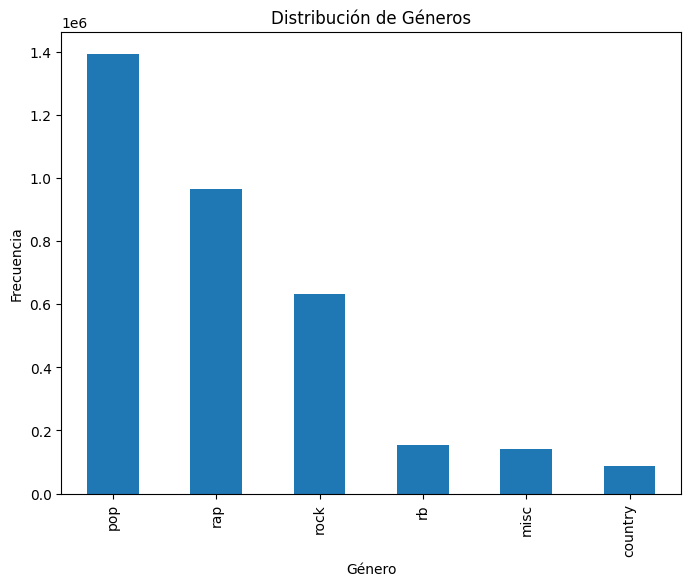

In [5]:
import matplotlib.pyplot as plt

tags = df['tag'].value_counts()

plt.figure(figsize=(8, 6))
tags.plot(kind='bar')
plt.title('Distribución de Géneros')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
tags = final_df['tag'].value_counts()

tags

,count
tag,
pop,10000
rap,10000
rb,10000
rock,10000
misc,10000
country,10000


In [11]:
drive.mount('/content/drive')

ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'

os.makedirs(ruta, exist_ok=True)

ruta_archivo = os.path.join(ruta, 'pop_en.csv')
final_df.to_csv(ruta_archivo, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Preprocesamiento

El siguiente paso será realizar un preprocesado de nuestro dataset. Aquí hay distintas cosas que podemos realizar como limpieza, tokenización, etc.

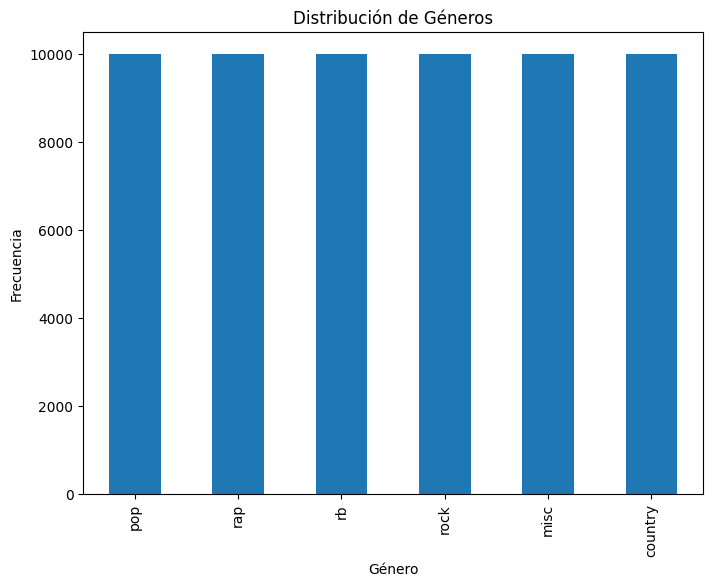

In [4]:
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'pop_en.csv')
df = pd.read_csv(ruta_archivo)

tags = df['tag'].value_counts()

plt.figure(figsize=(8, 6))
tags.plot(kind='bar')
plt.title('Distribución de Géneros')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.show()

#### 1. Limpieza

Empezaremos con una limpieza de la letra para eliminar sobre todo mayúsculas. También podemos reducir la dimensionalidad para quedarnos solo con el género y la letra.

In [6]:
df = df
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          59998 non-null  object
 1   tag            60000 non-null  object
 2   artist         60000 non-null  object
 3   year           60000 non-null  int64 
 4   views          60000 non-null  int64 
 5   features       60000 non-null  object
 6   lyrics         60000 non-null  object
 7   id             60000 non-null  int64 
 8   language_cld3  60000 non-null  object
 9   language_ft    60000 non-null  object
 10  language       60000 non-null  object
dtypes: int64(3), object(8)
memory usage: 5.0+ MB
None


In [7]:
del df['title']
del df['features']
del df['views']
del df['year']
del df['artist']
del df['language_cld3']
del df['language']
del df['language_ft']
del df['id']
df

,tag,lyrics
0,pop,Wanting you to know you've lost all taste\nDis...
1,pop,[Verse 1]\nCan we talk now?\nI need to tell yo...
2,pop,[Verse 1]\nHow does it feel\nWhen you're left ...
3,pop,"Dear Master Suzuki, I am writing you today\nYo..."
4,pop,Confession's of the brakeman's son\nVindicatin...
...,...,...
59995,country,"(You be coming through, you be coming through ..."
59996,country,[Chorus]\nSun's going to shine in my back door...
59997,country,You want this yea\n\nAnd the timings so right\...
59998,country,"[Verse 1]\nHello darlin', my it's good to hear..."


In [8]:
import re

def preprocess_text(text):
  text = re.sub(r"\[.*?\]", "", text)
  text = re.sub(r"\n\s*\n", "\n", text)
  text = text.lower()
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  return text.strip()

df['lyrics'] = df['lyrics'].apply(preprocess_text)
df

# text = preprocess_text("[Chorus]\nIn the nigh")
# text

,tag,lyrics
0,pop,wanting you to know youve lost all taste disre...
1,pop,can we talk now i need to tell you whats on my...
2,pop,how does it feel when youre left sitting out i...
3,pop,dear master suzuki i am writing you today you ...
4,pop,confessions of the brakemans son vindicating s...
...,...,...
59995,country,you be coming through you be coming through th...
59996,country,suns going to shine in my back door some day m...
59997,country,you want this yea and the timings so right bit...
59998,country,hello darlin my its good to hear you im at the...


```python
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'pop_filtred_1.csv')
df.to_csv(ruta_archivo, index=False)
```

In [9]:
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'pop_comb.csv')
df.to_csv(ruta_archivo, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2. Tokenización, lematización y stop words

Lo siguiente será procesar el texto resultante de cada letra y extraer las palabras claves que identifican las letras de estilo pop. Podemos usar para realizar esta labor las librerías `NLTK` y `spaCy`, nosotros usaremos esta última ya que soporta mejor otros idiomas distintos al inglés y dado que el tema de las tildes no las hemos tratado o no sabemos que más idiomas hay dentro del DataFrame usaremos esta librería.

In [ ]:
language_counts = df['language'].value_counts()
language_counts

,count
language,
en,1393559
es,167575
pt,74437
fr,59854
it,56854
...,...
mt,4
lb,2
tg,2


Hemos enontrado que nuestro dataframe con solo el género pop cuenta con la friolera de 84 idiomas distintos. Lo que es un desafío muy duro y que además es posible que haya algún idioma que no esté soportado por `spaCy`.

```python
# Versión 1 => Resultado: DataFrame de 60 idiomas
LANG_SPACY = ['ca', 'zh', 'hr', 'da', 'nl', 'en', 'fi', 'fr', 'de', 'el', 'it', 'ja',
              'ko', 'lt', 'mk', 'xx', 'nb', 'pl', 'pt', 'ro', 'ru', 'sl', 'es', 'sv',
              'uk', 'af', 'sq', 'am', 'grc', 'ar', 'hy', 'az', 'eu', 'bn', 'bg', 'cs',
              'et', 'fo', 'gu', 'he', 'hi', 'hu', 'is', 'id', 'ga', 'kn', 'ky', 'la',
              'lv', 'lij', 'dsb', '	lg', 'lb', 'ms', 'ml', 'mr', 'ne', 'nn', 'fa', 'sa',
              'sr', 'tn', 'si', 'sk', 'tl', 'ta', 'tt', 'te', 'th', 'ti', 'tr', 'hsb',
              'ur', 'vi', 'yo']
```

In [ ]:
LANG_SPACY = ['ca', 'zh', 'hr', 'da', 'nl', 'en', 'fi', 'fr', 'de', 'el', 'it', 'ja',
              'ko', 'lt', 'mk', 'xx', 'nb', 'pl', 'pt', 'ro', 'ru', 'sl', 'es', 'sv',
              'uk']

df = df[df['language'].isin(LANG_SPACY)]

In [ ]:
language_counts = df['language'].value_counts()
print(len(language_counts))

23


Ahora nuestro dataframe solo cuenta con 23 idiomas de los 84 que había antes y que son compatibles con `spaCy`.

```python
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'pop_filtred_2.csv')
df.to_csv(ruta_archivo, index=False)
```

In [ ]:
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
os.makedirs(ruta, exist_ok=True)
ruta_archivo = os.path.join(ruta, 'pop_filtred_2.csv')
df = pd.read_csv(ruta_archivo)
df

Mounted at /content/drive


,tag,lyrics,id,language
0,pop,what are words worth what are words worth word...,242,en
1,pop,in december drinking horchata id look psychoti...,384,en
2,pop,in the night i hear em talk the coldest story ...,526,en
3,pop,flashing lights lights lights flashing lights ...,523,en
4,pop,oh woah oh woah oh woah you know you love me i...,566,en
...,...,...,...,...
1966061,pop,at this crossroads i dont wanna go and gamble ...,7882831,en
1966062,pop,everything is alright now oh yes baby everythi...,7882838,en
1966063,pop,half truth and half you didnt we say were thro...,7882840,en
1966064,pop,dance for me now keeping yourself moving youre...,7882842,en


Una vez hemos seleccionado los idiomas compatibles lo siguiente es realizar la tokenización, lematización y stop words.

```python
# Versión 1
def process_text(text, lang):
  try:
    base_lang = lang + "_core_web_sm"
    nlp = spacy.load(base_lang)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return tokens
  except Exception as e:
    print(f"Error processing text in language '{lang}': {e}")
    return None

df_tokens = pd.DataFrame(columns=['language', 'tokens'])
df_tokens['language'] = df['language']
df_tokens['tokens'] = df.apply(lambda row: process_text(row['lyrics'], row['language']), axis=1)
```
Hemos intentado utilizar esta función que realiza las tres tareas de tokenización, lematización y stop words en base al idioma de la canción. Pero debido a la complejidad del DataFrame, la optimización era bastante baja tardando más de 1 hora en terminar el proceso.

Por lo que nos vimos forzados a cambiar de estrategia y decidimos optar por los embbedings con transformers para realizar el proceso.

## 3. Representación del texto

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

batch_size = 32
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def sentence_to_embedding(sentence, tokenizer, model):
    embeddings = []
    for i in range(0, len(sentence), batch_size):
        batch = sentence[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden_states = outputs.last_hidden_state
        return last_hidden_states

lyrics = df['lyrics'].astype(str).tolist()
embedding = sentence_to_embedding(lyrics, tokenizer, model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [ ]:
embedding

tensor([[[ 0.0838,  0.0822,  0.0586,  ..., -0.0073,  0.0853, -0.0193],
         [-0.0062,  0.0720, -0.0840,  ...,  0.2201, -0.0571, -0.0678],
         [-0.0277, -0.0229,  0.0330,  ...,  0.4336, -0.0262, -0.0782],
         ...,
         [ 0.0365,  0.0188,  0.0573,  ..., -0.0678,  0.1165, -0.0010],
         [ 0.0830,  0.0421, -0.0140,  ..., -0.0700,  0.0428,  0.0187],
         [ 0.0735,  0.0757,  0.0151,  ..., -0.0711,  0.0312,  0.0126]],

        [[ 0.0587,  0.0850,  0.0517,  ..., -0.0135,  0.0739,  0.0357],
         [-0.0769,  0.0975, -0.1344,  ...,  0.2023,  0.0613,  0.0525],
         [-0.0040,  0.1443, -0.0554,  ..., -0.1775, -0.0281,  0.1899],
         ...,
         [ 0.0511,  0.0780,  0.0081,  ..., -0.0753,  0.0210,  0.0712],
         [ 0.0511,  0.0780,  0.0081,  ..., -0.0753,  0.0210,  0.0712],
         [ 0.0511,  0.0780,  0.0081,  ..., -0.0753,  0.0210,  0.0712]],

        [[ 0.0790,  0.0688,  0.0616,  ...,  0.0090,  0.1006,  0.0183],
         [-0.1245, -0.0474, -0.1306,  ...,  0



```python
# Convertir el tensor de PyTorch a un array NumPy
embeddings_np = embedding.cpu().numpy()

# Calculate the average embedding for each sentence
embeddings_averaged = np.mean(embeddings_np, axis=1)

# Crear un DataFrame de Pandas a partir del array NumPy
df_embeddings = pd.DataFrame(embeddings_averaged)

# Guardar el DataFrame en un archivo CSV
df_embeddings.to_csv('/content/embedding.csv', index=False)
```



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

embedding_np = embedding.cpu().numpy()

pooled_embeddings = np.mean(embedding_np, axis=1)

# df_embeddings = pd.DataFrame(embeddings_averaged)

labels = np.ones(len(pooled_embeddings))

X_train, X_test, y_train, y_test = train_test_split(pooled_embeddings, labels, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

---

# Importar modelos

In [2]:
# Load the preprocessed data
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'pop_comb.csv')
df = pd.read_csv(ruta_archivo)

for index, row in df.iterrows():
    if row['tag'] != 'pop':
        df.at[index, 'tag'] = 'non-pop'

df

Mounted at /content/drive


,tag,lyrics
0,pop,what are words worth what are words worth word...
1,pop,in december drinking horchata id look psychoti...
2,pop,in the night i hear em talk the coldest story ...
3,pop,flashing lights lights lights flashing lights ...
4,pop,oh woah oh woah oh woah you know you love me i...
...,...,...
19995,non-pop,the sun goes down and i crept out the cemetery...
19996,non-pop,bitch you can straight up eat a mothafuckin di...
19997,non-pop,yup yup thats me chris lowe yeah thats me oh i...
19998,non-pop,killas kick the anthem like this juggalos up i...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
vectorizer.fit(df['lyrics'])

X = vectorizer.transform(df['lyrics'])
y = df['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
import pickle
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
archivo_01 = os.path.join(ruta, 'pop_detected_02a.sav')
archivo_02 = os.path.join(ruta, 'pop_detected_1.0a.sav')
archivo_03 = os.path.join(ruta, 'pop_detected_network_01a.sav')
archivo_04 = os.path.join(ruta, 'pop_detected_network_1.0a.sav')
archivo_05 = os.path.join(ruta, 'pop_detected_sgdclass_01a.sav')

model_01 = pickle.load(open(archivo_01, 'rb'))
model_02 = pickle.load(open(archivo_02, 'rb'))
model_03 = pickle.load(open(archivo_03, 'rb'))
model_04 = pickle.load(open(archivo_04, 'rb'))
model_05 = pickle.load(open(archivo_05, 'rb'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from sklearn.preprocessing import LabelEncoder

# Encode labels to numerical values (0 and 1)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

y_pred = model_01.predict(X_test)
y_pred2 = model_02.predict(X_test)
y_pred3 = (model_03.predict(X_test.toarray()) > 0.5).astype("int32")
y_pred3_labels = label_encoder.inverse_transform(y_pred3.flatten())
y_pred4 = (model_04.predict(X_test.toarray()) > 0.5).astype("int32")
y_pred4_labels = label_encoder.inverse_transform(y_pred4.flatten())
y_pred5 = model_05.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


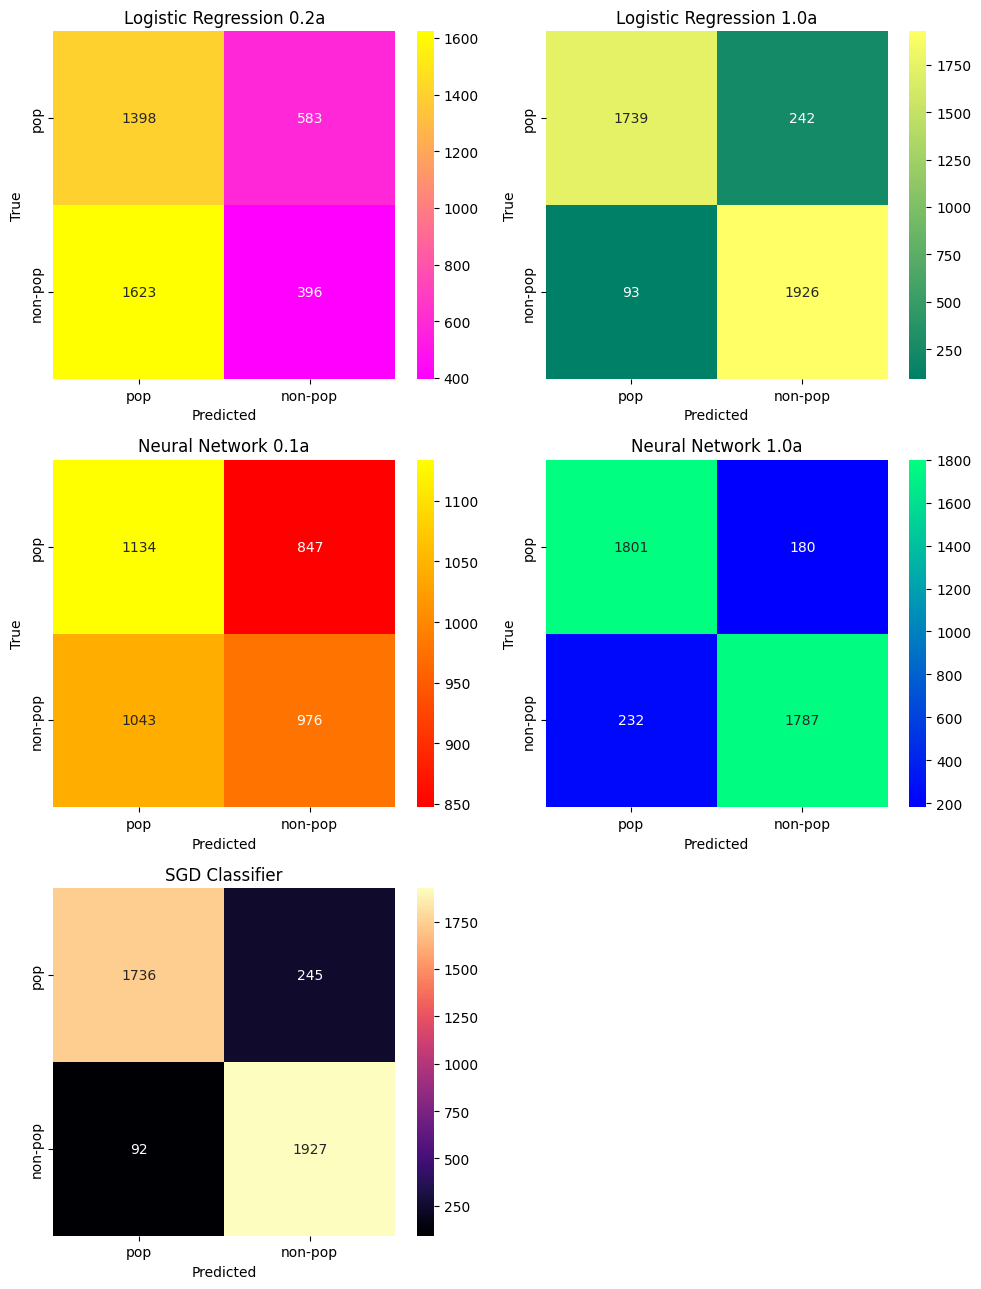

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

CLASSES = df['tag'].unique()

cm = confusion_matrix(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred2)
cm3 = confusion_matrix(y_test, y_pred3_labels)
cm4 = confusion_matrix(y_test, y_pred4_labels)
cm5 = confusion_matrix(y_test, y_pred5)

plt.figure(figsize=(10, 13))
plt.subplot(3, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='spring', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Logistic Regression 0.2a')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(3, 2, 2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='summer', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Logistic Regression 1.0a')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(3, 2, 3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='autumn', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Neural Network 0.1a')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(3, 2, 4)
sns.heatmap(cm4, annot=True, fmt='d', cmap='winter', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Neural Network 1.0a')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(3, 2, 5)
sns.heatmap(cm5, annot=True, fmt='d', cmap='magma', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('SGD Classifier')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

# Reentrenamiento

In [ ]:
# Load the preprocessed data
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/Google Colab/PIA/data/'
ruta_archivo = os.path.join(ruta, 'new_pop_3.csv')
df2 = pd.read_csv(ruta_archivo)

df2 = df2.rename(columns={'genre': 'tag'})

df2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,tag,lyrics,tokens
0,pop,hold time feel break feel untrue convince spea...,"['hold', 'time', 'feel', 'break', 'feel', 'unt..."
1,pop,believe drop rain fall grow believe darkest ni...,"['believe', 'drop', 'rain', 'fall', 'grow', 'b..."
2,pop,sweetheart send letter goodbye secret feel bet...,"['sweetheart', 'send', 'letter', 'goodbye', 's..."
3,pop,kiss lips want stroll charm mambo chacha merin...,"['kiss', 'lip', 'want', 'stroll', 'charm', 'ma..."
4,pop,till darling till matter know till dream live ...,"['till', 'darling', 'till', 'matter', 'know', ..."
...,...,...,...
15675,non-pop,yesterday felt like yesterday want walk away c...,"['yesterday', 'feel', 'like', 'yesterday', 'wa..."
15676,non-pop,depress mess want smile take hide surprise lig...,"['depress', 'mess', 'want', 'smile', 'hide', '..."
15677,non-pop,look look look years bring lower believe light...,"['look', 'look', 'look', 'year', 'bring', 'low..."
15678,non-pop,complain stand wait dance uhhuh wanna talk kno...,"['complain', 'stand', 'wait', 'dance', 'uhhuh'..."


In [ ]:
X2 = vectorizer.transform(df2['lyrics'])
y2 = df2['tag']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)
model_05.partial_fit(X_train2, y_train2)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


SGDClassifier(alpha=0.001, max_iter=5, random_state=42, tol=None)

In [ ]:
from sklearn.metrics import classification_report
from scipy.sparse import vstack
X_test_comb = vstack((X_test, X_test2))
y_test_comb = np.concatenate((y_test, y_test2))
y_new_pred = model_05.predict(X_test_comb)
print("\nClassification Report:\n", classification_report(y_test_comb, y_new_pred))


Classification Report:
               precision    recall  f1-score   support

     non-pop       0.66      0.87      0.75      3713
         pop       0.78      0.52      0.62      3423

    accuracy                           0.70      7136
   macro avg       0.72      0.69      0.69      7136
weighted avg       0.72      0.70      0.69      7136



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


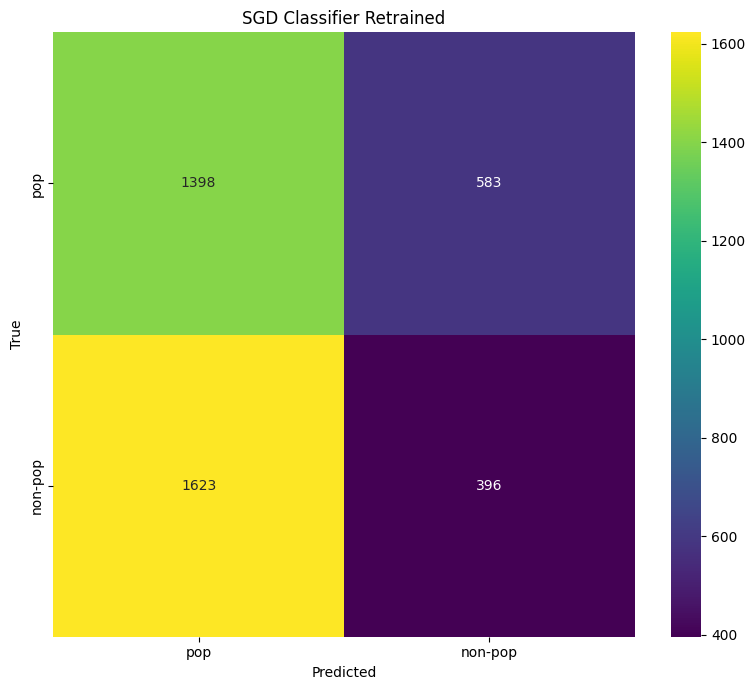

In [ ]:
cm_imp = confusion_matrix(y_test_comb, y_new_pred)

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('SGD Classifier Retrained')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [8]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # Tokenización, lematización y eliminación de stop words
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return tokens

def classify_song():
    lyrics = input("Introduce las lyrics de la canción: ")

    # Preprocess the input lyrics
    tokens = preprocess_text(lyrics)
    lyrics_processed = " ".join(tokens)

    # Vectorize the lyrics using the same TF-IDF vectorizer
    lyrics_tfidf = vectorizer.transform([lyrics_processed])

    # Predict using the logistic regression model
    prediction_lr = model_02.predict(lyrics_tfidf)[0]

    # Predict using the neural network model
    prediction_nn = (model_04.predict(lyrics_tfidf) > 0.5).astype("int32")[0][0]
    prediction_nn = label_encoder.inverse_transform([prediction_nn])[0]

    # Predict using the SGD Classifier model
    prediction_sgd = model_05.predict(lyrics_tfidf)[0]


    print(f"Predicción con Regresión Logística: {prediction_lr}")
    print(f"Predicción con Red Neuronal: {prediction_nn}")
    print(f"Predicción con SGD Classifier: {prediction_sgd}")

classify_song()

Introduce las lyrics de la canción: You get me high as Willie girl You get me gone as Jones You turn me on as much as I turn on my radio Let's take our time, walk the line kinda like Johnny and June did Yeah, let's do this Baby, I love you like I love country music 'Cause I could never live without ya Or my favorite songs about ya Top to bottom perfect, you're like Brooks & Dunn's debut album You got me feeling like I'm a brand new man Yes, I am Baby, I love you like I love country music You get me high as Willie, girl You get me gone as Jones You turn me on as much as I turn on my radio Let's take our time, walk the line Kinda like Johnny and June did Yeah, let's do this Baby, I love you like I love country music


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Predicción con Regresión Logística: pop
Predicción con Red Neuronal: pop
Predicción con SGD Classifier: pop


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
